<a href="https://colab.research.google.com/github/JangAyeon/TIL/blob/main/3_5_classifying_newswires.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **뉴스 기사 분류 : 다중 분류 문제**

* 다중 분류 (multiclass classification)
* 단일 레이블 다중 분류 : 각 데이터 포인트가 정확히 하나의 범주로 분류됨
* 다중 레이블 다중 분류 : 각 데이터 포인터가 여러 개의 범주에 속할 수 있음

In [ ]:
import keras
keras.__version__

'2.6.0'

In [ ]:
import numpy as np

## **로이터 데이터셋**

In [ ]:
# 로이터 데이터 셋 로드
from keras.datasets import reuters
(train_data, train_labels), (test_data, test_labels) = reuters.load_data(num_words=10000)
# num_words=1000 : 데이터에서 가장 자주 등장하는 단어 1만개로 제한

In [ ]:
print("# of train data : ",len(train_data))
print("# of test data : ",len(test_data))

# of train data :  8982
# of test data :  2246


In [ ]:
train_data[10] #각 샘플은 정수 리스트 (단어 인덱스)

[1,
 245,
 273,
 207,
 156,
 53,
 74,
 160,
 26,
 14,
 46,
 296,
 26,
 39,
 74,
 2979,
 3554,
 14,
 46,
 4689,
 4329,
 86,
 61,
 3499,
 4795,
 14,
 61,
 451,
 4329,
 17,
 12]

In [ ]:
#로이터 데이터셋을 텍스트로 디코딩하기
word_index=reuters.get_word_index()
reverse_word_index=dict([(value,key) for (key,value) in word_index.items()])
decoded_newswire=' '.join([reverse_word_index.get(i-3,"?")for i in train_data[0]]) # 0, 1, 2는 패딩, 문서 시작, 사전에 없음을 위한 인덱스 임으로 3 빼기

In [ ]:
decoded_newswire #텍스트

'? ? ? said as a result of its december acquisition of space co it expects earnings per share in 1987 of 1 15 to 1 30 dlrs per share up from 70 cts in 1986 the company said pretax net should rise to nine to 10 mln dlrs from six mln dlrs in 1986 and rental operation revenues to 19 to 22 mln dlrs from 12 5 mln dlrs it said cash flow per share this year should be 2 50 to three dlrs reuter 3'

In [ ]:
np.unique(train_labels) #출력 클래스 갯수 : 46개 (다중 분류)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45])

In [ ]:
train_labels[10] #샘플에 연결된 레이블은 토픽의 인덱스로 0 ~ 45 사이의 정수

3

## **데이터 준비**

**레이블 -> 벡터로 변환하는 방법 2가지**<br>
1. 레이블의 리스트를 정수 텐서로 변환
2. 원-핫 인코딩<br>
각 레이블의 인덱스 자리는 1이고 나머지는 모두 0인 벡터

In [ ]:
#데이터 인코딩하기


def vectorize_sequences(sequences, dimension=10000):
    results = np.zeros((len(sequences), dimension))
    for i, sequence in enumerate(sequences):
        results[i, sequence] = 1.
    return results

# 훈련 데이터 벡터 변환
x_train = vectorize_sequences(train_data)
# 테스트 데이터 벡터 변환
x_test = vectorize_sequences(test_data)

In [ ]:
def to_one_hot(labels, dimension=46):
    results = np.zeros((len(labels), dimension))
    for i, label in enumerate(labels):
        results[i, label] = 1.
    return results

# 훈련 레이블 벡터 변환
one_hot_train_labels = to_one_hot(train_labels)
# 테스트 레이블 벡터 변환
one_hot_test_labels = to_one_hot(test_labels)

In [ ]:
from keras.utils.np_utils import to_categorical
#케라스에는 one-hot encoding을 위한 내장 함수 있음

one_hot_train_labels = to_categorical(train_labels)
one_hot_test_labels = to_categorical(test_labels)

## **모델 구성**

**정보의 병목**
* dense 층은 이전 층의 출력 정보만 사용가능<br>-> 한 층의 분류에서 정보 누락 시 다음 층에서 복원 불가능 
* 규모가 작으면 유용한 정보를 완전히 잃게 되는 정보 병목의 지점이 될 가능성 가짐<br>-> 이진 분류에서 16차원 가진 중간층 사용했지만 46개 클래스 구분에 한계 있음

In [ ]:
#모델 정의
from keras import models
from keras import layers

model = models.Sequential()
model.add(layers.Dense(64, activation='relu', input_shape=(10000,)))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(46, activation='softmax')) 


`model.add(layers.Dense(46, activation='softmax')) 
`
1.  마지막 dense층 크기 46<br>
각 입력 샘플에 대해 46개 차원의 벡터 출력 <br>-> 이 벡터의 각 원손는 각기 다른 출력 클래스가 인코딩됨

2. softmax 활성화 함수
각 입력 샘플마다 n개의 출력 클래스에 대한 확률분포 출력
-> 46차원 출력 벡터 output[i]는 해당 샘플이 클래스 i에 속할 확률 의미
-> 46개의 값을 더하면 1



In [ ]:
#모델 컴파일하기
model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

`model.compile(optimizer='rmsprop',loss='categorical_crossentropy', metrics=['accuracy'])`<br>
1. categorical_crossentropy 손실함수<br>
네트워크가 출력한 확률 분포와 true 레이블의 분포 사이 거리 측정<br>-> 이 두 분포 사이의 거리를 최소화래 true 레이블에 근사한 출력하도록 모델 훈련


## **훈련 검증**

In [ ]:
#검증 세트 준비하기 : 훈련 데이터에서 1000개 따로 떼어 검증 세트 사용

x_val = x_train[:1000]
partial_x_train = x_train[1000:]

y_val = one_hot_train_labels[:1000]
partial_y_train = one_hot_train_labels[1000:]

In [ ]:
#모델 훈련하기 : epoch 20개로 모델 훈련
history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=20,
                    batch_size=512,
                    validation_data=(x_val, y_val))

Epoch 1/20
16/16 [==============================] - 1s 52ms/step - loss: 2.6732 - accuracy: 0.5267 - val_loss: 1.7069 - val_accuracy: 0.6500
Epoch 2/20
16/16 [==============================] - 1s 39ms/step - loss: 1.3923 - accuracy: 0.7172 - val_loss: 1.2651 - val_accuracy: 0.7280
Epoch 3/20
16/16 [==============================] - 1s 39ms/step - loss: 1.0278 - accuracy: 0.7781 - val_loss: 1.1407 - val_accuracy: 0.7400
Epoch 4/20
16/16 [==============================] - 1s 38ms/step - loss: 0.8066 - accuracy: 0.8239 - val_loss: 1.0271 - val_accuracy: 0.7770
Epoch 5/20
16/16 [==============================] - 1s 39ms/step - loss: 0.6468 - accuracy: 0.8609 - val_loss: 0.9790 - val_accuracy: 0.8010
Epoch 6/20
16/16 [==============================] - 1s 38ms/step - loss: 0.5183 - accuracy: 0.8899 - val_loss: 0.9258 - val_accuracy: 0.8100
Epoch 7/20
16/16 [==============================] - 1s 39ms/step - loss: 0.4183 - accuracy: 0.9114 - val_loss: 0.9062 - val_accuracy: 0.8120
Epoch 8/20
16

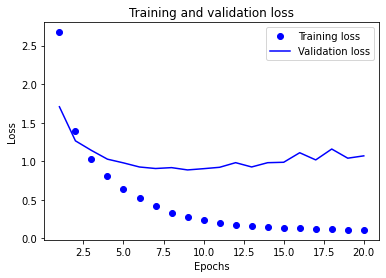

In [ ]:
#훈련과 검증 손실 그리기
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

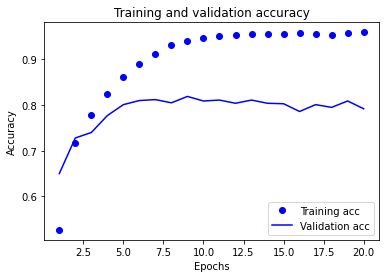

In [ ]:
#훈련과 검증 정확도 그리기
plt.clf()   # 그래프를 초기화합니다

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [ ]:
#모델을 처음부터 다시 훈련하기

model=models.Sequential()
model.add(layers.Dense(64,activation='relu',input_shape=(10000,)))
model.add(layers.Dense(64,activation="relu"))
model.add(layers.Dense(46,activation="softmax"))

model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

history=model.fit(partial_x_train,
          partial_y_train,
          epochs=9,
          batch_size=512,
          validation_data=(x_val, y_val))
results=model.evaluate(x_test,one_hot_test_labels)

Epoch 1/9
16/16 [==============================] - 1s 48ms/step - loss: 2.7571 - accuracy: 0.4959 - val_loss: 1.8116 - val_accuracy: 0.6360
Epoch 2/9
16/16 [==============================] - 1s 39ms/step - loss: 1.4763 - accuracy: 0.6969 - val_loss: 1.3495 - val_accuracy: 0.7080
Epoch 3/9
16/16 [==============================] - 1s 37ms/step - loss: 1.0918 - accuracy: 0.7598 - val_loss: 1.1673 - val_accuracy: 0.7460
Epoch 4/9
16/16 [==============================] - 1s 38ms/step - loss: 0.8640 - accuracy: 0.8148 - val_loss: 1.0488 - val_accuracy: 0.7850
Epoch 5/9
16/16 [==============================] - 1s 37ms/step - loss: 0.6893 - accuracy: 0.8547 - val_loss: 0.9861 - val_accuracy: 0.7920
Epoch 6/9
16/16 [==============================] - 1s 38ms/step - loss: 0.5560 - accuracy: 0.8871 - val_loss: 0.9257 - val_accuracy: 0.8140
Epoch 7/9
16/16 [==============================] - 1s 38ms/step - loss: 0.4476 - accuracy: 0.9090 - val_loss: 0.8982 - val_accuracy: 0.8110
Epoch 8/9
16/16 [===

**정확도**
* 정확도 : 78%
* 균형 잡힌 데이터셋 무작위로 분류한 경우 : 정확도 50%
* 불균형한 이 데이터셋을 무작위로 분류한 경우 : 정확도 18% 

In [ ]:
results #정확도 : 78%

[1.0043619871139526, 0.7876224517822266]

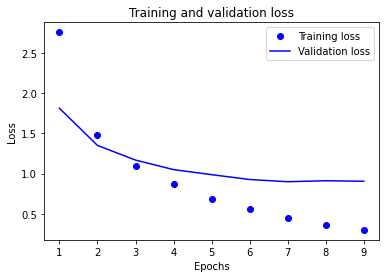

In [ ]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [ ]:
import copy
test_labels_copy=copy.copy(test_labels)
np.random.shuffle(test_labels_copy)
float(np.sum(np.array(test_labels)==np.array(test_labels_copy)))/len(test_labels) 
#무작위로 분류한 경우 정확도 : 18%

0.1794300979519145

## **새로운 데이터에 대해 예측하기**

`model.predict(x_test)` <br>
모델 인스턴스의 predict 메서드는 46개 class에 대한 확률 분포 반환


In [ ]:
#새로운 데이터에 대해 예측하기
predictions=model.predict(x_test)

In [ ]:
predictions[0].shape #prediction 각 항목의 길이 = 46인 벡터

(46,)

In [ ]:
np.sum(predictions[0]) #이 벡터의 원소 합 =1

0.99999994

In [ ]:
np.argmax(predictions[0]) #가장 확률이 높은 class

3

## **레이블과 손실을 다루는 다른 방법**

In [ ]:
#정수 텐서로 변환해 레이블 인코딩
y_train = np.array(train_labels)
y_test = np.array(test_labels)

In [ ]:
#정수 레이블 사용 시, 손실함수 'sparse_categorical_crossentropy' 사용
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy', metrics=['acc'])

## **충분히 큰 중간층을 두어야 하는 이유**

In [ ]:
#정보 병목이 있는 모델
model = models.Sequential()
model.add(layers.Dense(64, activation='relu', input_shape=(10000,)))
model.add(layers.Dense(4, activation='relu'))
model.add(layers.Dense(46, activation='softmax'))

model.compile(optimizer="rmsprop",
              loss="categorical_crossentropy",
              metrics=["accuracy"])


history = model.fit(partial_x_train,
          partial_y_train,
          epochs=20,
          batch_size=128,
          validation_data=(x_val,y_val))


Epoch 1/20
63/63 [==============================] - 2s 16ms/step - loss: 3.3314 - accuracy: 0.2289 - val_loss: 2.8530 - val_accuracy: 0.2520
Epoch 2/20
63/63 [==============================] - 1s 14ms/step - loss: 2.3777 - accuracy: 0.4173 - val_loss: 1.9603 - val_accuracy: 0.5820
Epoch 3/20
63/63 [==============================] - 1s 14ms/step - loss: 1.6523 - accuracy: 0.6176 - val_loss: 1.6290 - val_accuracy: 0.6190
Epoch 4/20
63/63 [==============================] - 1s 15ms/step - loss: 1.4281 - accuracy: 0.6334 - val_loss: 1.5426 - val_accuracy: 0.6210
Epoch 5/20
63/63 [==============================] - 1s 14ms/step - loss: 1.2994 - accuracy: 0.6433 - val_loss: 1.5009 - val_accuracy: 0.6370
Epoch 6/20
63/63 [==============================] - 1s 14ms/step - loss: 1.1928 - accuracy: 0.6689 - val_loss: 1.4940 - val_accuracy: 0.6330
Epoch 7/20
63/63 [==============================] - 1s 14ms/step - loss: 1.1015 - accuracy: 0.6934 - val_loss: 1.4742 - val_accuracy: 0.6460
Epoch 8/20
63

마지막 출력은 46차원임으로 중간 층의 히든 유닛이 46개보다 많이 적으면 안됨<br>

`case` : 46차원보다 더 적은 중간층(4차원)을 둔 경우, 정보의 병목 양상
* `결과` : 검증 정확도 최고 값이 71%로 충분히 큰 중간층을 둔 모델에 비해 8%정도 감소됨
* `손실 원인` : 46개 클래스의 분할 초평면을 복원하기에 충분한 정보를 중간층의 저차원 표현 공간으로 압출하려고 했기 때문


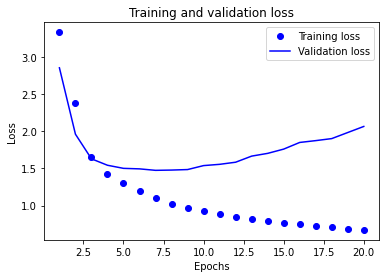

In [ ]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

## **추가 실험**

###더 큰 128개의 유닛인 경우

In [ ]:

model = models.Sequential()
model.add(layers.Dense(128, activation='relu', input_shape=(10000,)))
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(46, activation='softmax'))

model.compile(optimizer="rmsprop",
              loss="categorical_crossentropy",
              metrics=["accuracy"])


history=model.fit(partial_x_train,
          partial_y_train,
          epochs=20,
          batch_size=128,
          validation_data=(x_val,y_val))

Epoch 1/20
63/63 [==============================] - 2s 24ms/step - loss: 1.5591 - accuracy: 0.6616 - val_loss: 1.1045 - val_accuracy: 0.7380
Epoch 2/20
63/63 [==============================] - 1s 21ms/step - loss: 0.7642 - accuracy: 0.8301 - val_loss: 0.9071 - val_accuracy: 0.7990
Epoch 3/20
63/63 [==============================] - 1s 21ms/step - loss: 0.4564 - accuracy: 0.8985 - val_loss: 0.8630 - val_accuracy: 0.8150
Epoch 4/20
63/63 [==============================] - 1s 21ms/step - loss: 0.2946 - accuracy: 0.9326 - val_loss: 0.8824 - val_accuracy: 0.8190
Epoch 5/20
63/63 [==============================] - 1s 21ms/step - loss: 0.2276 - accuracy: 0.9450 - val_loss: 0.9281 - val_accuracy: 0.8160
Epoch 6/20
63/63 [==============================] - 1s 21ms/step - loss: 0.1873 - accuracy: 0.9515 - val_loss: 0.9260 - val_accuracy: 0.8210
Epoch 7/20
63/63 [==============================] - 1s 21ms/step - loss: 0.1661 - accuracy: 0.9531 - val_loss: 0.9416 - val_accuracy: 0.8200
Epoch 8/20
63

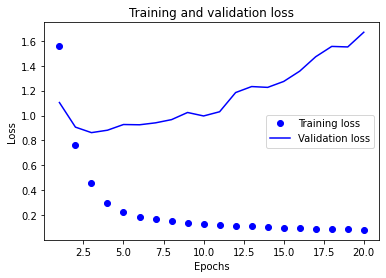

In [ ]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

###더 작은 32개 유닛인 경우

In [ ]:

model = models.Sequential()
model.add(layers.Dense(32, activation='relu', input_shape=(10000,)))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(46, activation='softmax'))

model.compile(optimizer="rmsprop",
              loss="categorical_crossentropy",
              metrics=["accuracy"])


history=model.fit(partial_x_train,
          partial_y_train,
          epochs=20,
          batch_size=128,
          validation_data=(x_val,y_val))

Epoch 1/20
63/63 [==============================] - 1s 13ms/step - loss: 2.4224 - accuracy: 0.5504 - val_loss: 1.5180 - val_accuracy: 0.6800
Epoch 2/20
63/63 [==============================] - 1s 10ms/step - loss: 1.2318 - accuracy: 0.7279 - val_loss: 1.1881 - val_accuracy: 0.7280
Epoch 3/20
63/63 [==============================] - 1s 10ms/step - loss: 0.9191 - accuracy: 0.7992 - val_loss: 1.0527 - val_accuracy: 0.7660
Epoch 4/20
63/63 [==============================] - 1s 11ms/step - loss: 0.7095 - accuracy: 0.8406 - val_loss: 0.9661 - val_accuracy: 0.7890
Epoch 5/20
63/63 [==============================] - 1s 10ms/step - loss: 0.5525 - accuracy: 0.8804 - val_loss: 0.9322 - val_accuracy: 0.8040
Epoch 6/20
63/63 [==============================] - 1s 10ms/step - loss: 0.4345 - accuracy: 0.9083 - val_loss: 0.9129 - val_accuracy: 0.8150
Epoch 7/20
63/63 [==============================] - 1s 10ms/step - loss: 0.3472 - accuracy: 0.9243 - val_loss: 0.9394 - val_accuracy: 0.8140
Epoch 8/20
63

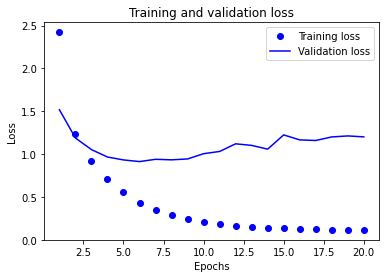

In [ ]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

###1개의 은닉층 사용

In [ ]:

model = models.Sequential()
model.add(layers.Dense(64, activation='relu', input_shape=(10000,)))
model.add(layers.Dense(46, activation='softmax'))

model.compile(optimizer="rmsprop",
              loss="categorical_crossentropy",
              metrics=["accuracy"])


history=model.fit(partial_x_train,
          partial_y_train,
          epochs=20,
          batch_size=128,
          validation_data=(x_val,y_val))

Epoch 1/20
63/63 [==============================] - 1s 17ms/step - loss: 1.8346 - accuracy: 0.6481 - val_loss: 1.2033 - val_accuracy: 0.7410
Epoch 2/20
63/63 [==============================] - 1s 13ms/step - loss: 0.9331 - accuracy: 0.8034 - val_loss: 0.9752 - val_accuracy: 0.7990
Epoch 3/20
63/63 [==============================] - 1s 14ms/step - loss: 0.6375 - accuracy: 0.8711 - val_loss: 0.8711 - val_accuracy: 0.8170
Epoch 4/20
63/63 [==============================] - 1s 14ms/step - loss: 0.4542 - accuracy: 0.9070 - val_loss: 0.8331 - val_accuracy: 0.8240
Epoch 5/20
63/63 [==============================] - 1s 14ms/step - loss: 0.3381 - accuracy: 0.9287 - val_loss: 0.8150 - val_accuracy: 0.8240
Epoch 6/20
63/63 [==============================] - 1s 13ms/step - loss: 0.2644 - accuracy: 0.9417 - val_loss: 0.8429 - val_accuracy: 0.8280
Epoch 7/20
63/63 [==============================] - 1s 14ms/step - loss: 0.2180 - accuracy: 0.9475 - val_loss: 0.8580 - val_accuracy: 0.8280
Epoch 8/20
63

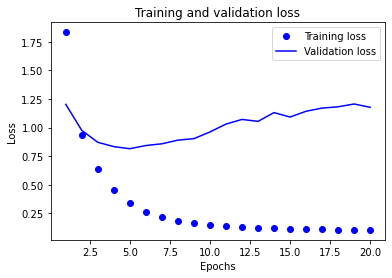

In [ ]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

###3개의 은닉층 사용

In [ ]:


model = models.Sequential()
model.add(layers.Dense(64, activation='relu', input_shape=(10000,)))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(46, activation='softmax'))

model.compile(optimizer="rmsprop",
              loss="categorical_crossentropy",
              metrics=["accuracy"])


history=model.fit(partial_x_train,
          partial_y_train,
          epochs=20,
          batch_size=128,
          validation_data=(x_val,y_val))

Epoch 1/20
63/63 [==============================] - 2s 17ms/step - loss: 1.8006 - accuracy: 0.6160 - val_loss: 1.2950 - val_accuracy: 0.6950
Epoch 2/20
63/63 [==============================] - 1s 14ms/step - loss: 0.9758 - accuracy: 0.7771 - val_loss: 1.0240 - val_accuracy: 0.7640
Epoch 3/20
63/63 [==============================] - 1s 15ms/step - loss: 0.6466 - accuracy: 0.8530 - val_loss: 1.0365 - val_accuracy: 0.7730
Epoch 4/20
63/63 [==============================] - 1s 14ms/step - loss: 0.4471 - accuracy: 0.9002 - val_loss: 1.0866 - val_accuracy: 0.7800
Epoch 5/20
63/63 [==============================] - 1s 14ms/step - loss: 0.3261 - accuracy: 0.9306 - val_loss: 0.9988 - val_accuracy: 0.8070
Epoch 6/20
63/63 [==============================] - 1s 14ms/step - loss: 0.2529 - accuracy: 0.9385 - val_loss: 1.0579 - val_accuracy: 0.7950
Epoch 7/20
63/63 [==============================] - 1s 14ms/step - loss: 0.2076 - accuracy: 0.9489 - val_loss: 1.0295 - val_accuracy: 0.8130
Epoch 8/20
63

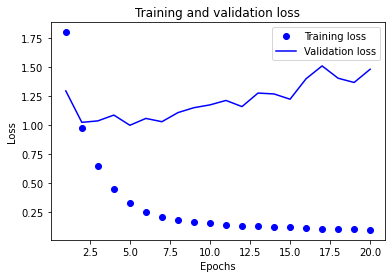

In [ ]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()